In [21]:
import pandas as pd
from models import *
import dateutil.parser
from sqlalchemy.sql import func
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker, joinedload, aliased
import matplotlib as plt
import numpy as np
import seaborn as sns
from secretstuff import connection_string

halibut_days = ['2018-05-11','2018-05-13', '2018-05-25', '2018-05-27', '2018-06-07', '2018-06-09',
                '2018-06-16', '2018-06-21', '2018-06-23', '2018-06-30']
catch_area = '06'
locations = ['1187', '1041', '1186', '1107']
out_folder = ''
sns.set_style('darkgrid')

#this is aerial so stick to convention and use .99999

site_weights = .9999

%matplotlib inline

In [2]:
engine = create_engine(connection_string)
session = sessionmaker()
session.configure(bind=engine)
s = session()
catch_sql = s.query(func.to_char(Survey.survey_datetime, 'YYYY-MM-DD').label('date'),
                  SpeciesLUT.common_name,
                  SpeciesLUT.species_code,
                  CatchResult.catch_result_type_code,
                  CatchArea.catch_area_code,
                  FishEncounter.fish_count)\
                 .join(SurveyEvent)\
                 .join(FishingMethod)\
                 .join(FishEncounter)\
                 .join(CatchArea)\
                 .join(CatchResult)\
                 .join(SpeciesLUT)\
                 .join(Location, Survey.location_id == Location.location_id)\
                 .filter(Survey.survey_type_id == 'a1c68f6d-dcfe-4b86-a00d-d8fab7057e2e')\
                 .filter(Survey.survey_datetime.in_(halibut_days))\
                 .filter(SurveyEvent.void_encounter_indicator == False)\
                 .filter(CatchArea.catch_area_code == catch_area)\
                 .filter(Location.location_code.in_(locations))\
                 .filter(SurveyEvent.uncooperative_angler_indicator == False)\
                 .filter(FishingMethod.fishing_method_short_description.in_(['Kicker angler','Charter angler']))


effort_sql = s.query(func.to_char(Survey.survey_datetime, 'YYYY-MM-DD').label('date'),
                  SurveyEvent.angler_count,
                  CatchArea.catch_area_code)\
                 .join(SurveyEvent)\
                 .join(FishingMethod)\
                 .join(CatchArea)\
                 .join(Location, Survey.location_id == Location.location_id)\
                 .filter(Survey.survey_type_id == 'a1c68f6d-dcfe-4b86-a00d-d8fab7057e2e')\
                 .filter(Survey.survey_datetime.in_(halibut_days))\
                 .filter(SurveyEvent.void_encounter_indicator == False)\
                 .filter(CatchArea.catch_area_code == catch_area)\
                 .filter(Location.location_code.in_(locations))\
                 .filter(SurveyEvent.uncooperative_angler_indicator == False)\
                 .filter(FishingMethod.fishing_method_short_description.in_(['Kicker angler','Charter angler']))


flights_sql = s.query(func.to_char(Survey.survey_datetime, 'YYYY-MM-DD').label('date'),
                      CatchArea.catch_area_code,
                      Survey.start_datetime,
                      Survey.end_datetime,
                      func.sum(BoatEncounter.boat_count).label('total_boats'))\
                      .join(SurveyEvent)\
                      .join(CatchArea)\
                      .join(BoatEncounter)\
                      .filter(Survey.survey_type_id == 'c29b9752-6c0e-4e45-9eac-5e450dd10dcc')\
                      .filter(func.to_char(Survey.survey_datetime, 'YYYY-MM-DD').in_(halibut_days))\
                      .filter(CatchArea.catch_area_code == catch_area)\
                      .filter(SurveyEvent.void_encounter_indicator == False)\
                    .group_by(Survey.survey_datetime, CatchArea.catch_area_code, Survey.start_datetime, Survey.end_datetime)\
                    .order_by(Survey.survey_datetime)


boats_sql = s.query(func.to_char(Survey.survey_datetime, 'YYYY-MM-DD').label('date'),
                      SurveyEvent.encounter_number,
                      SurveyEvent.survey_event_id,
                      DocksideEncounter.trip_start_datetime,
                      DocksideEncounter.trip_end_datetime,
                      FishingMethod.fishing_method_short_description,
                      CatchArea.catch_area_code)\
                     .join(SurveyEvent)\
                     .join(DocksideEncounter)\
                     .join(FishingMethod)\
                     .join(CatchArea)\
                     .filter(Survey.survey_type_id == 'a1c68f6d-dcfe-4b86-a00d-d8fab7057e2e')\
                     .filter(Survey.survey_datetime.in_(halibut_days))\
                     .filter(CatchArea.catch_area_code == catch_area)\
                     .filter(SurveyEvent.void_encounter_indicator == False)\
                     .filter(FishingMethod.fishing_method_short_description.in_(['Kicker angler','Charter angler', 'Not applicable']))\
                     .filter(DocksideEncounter.trip_start_datetime.isnot(None))\
                     .filter(DocksideEncounter.trip_end_datetime.isnot(None))\

                             
fish = pd.read_sql(sql=catch_sql.statement, con=s.bind)
flights = pd.read_sql(sql=flights_sql.statement, con=s.bind)
boats = pd.read_sql(sql=boats_sql.statement, con=s.bind)
effort = pd.read_sql(sql=effort_sql.statement, con=s.bind)
                             
s.close()

In [3]:
#prep the biological data by aggregating a melting it
### FISH ###
#sum by species, date, kept/released 
fish = fish.groupby(['date','common_name', 'species_code',
                     'catch_result_type_code','catch_area_code'], as_index=False)['fish_count'].sum()
### EFFORT ###
#counts the boats and sums the effort, then melts the columns to provide or vertical dataframe
anglers = effort.groupby(['date', 'catch_area_code']).agg({'angler_count': ['count','sum']})['angler_count'][['count','sum']].reset_index()
anglers.rename(columns={'count':'boats', 'sum':'anglers'}, inplace=True)
anglers_vert = anglers.melt(id_vars=['date', 'catch_area_code'], value_vars=['boats','anglers'], value_name='count')
anglers_vert['catch_result_type_code'] = 'NA'

In [4]:
#AERIAL
#merge the flights, [fishing] boats dataframes
aerial = pd.merge(flights, boats)


In [5]:
#filter by flight time, identifies boats that were fishing during the flight
# 1. if the trip start time is between the start and end of the flight in the area
# 2. if the trip end time is between the start and end of the flight in the area
# 3. if the trip start time is before the start of the flight, and the trip end time
#    is after the end of the flight
aerial_mask = ((aerial['trip_start_datetime'] >= aerial['start_datetime']) & \
                    (aerial['trip_start_datetime'] <= aerial['end_datetime'])) | \
                    ((aerial['trip_end_datetime'] >= aerial['start_datetime']) & \
                    (aerial['trip_end_datetime'] <= aerial['end_datetime'])) | \
                    ((aerial['trip_start_datetime'] <= aerial['start_datetime']) & \
                    (aerial['trip_end_datetime'] >= aerial['end_datetime']))
boats_on_water = aerial.loc[aerial_mask]
#save the boats not fishing for later
#WRITE SAVE HERE
boats_off_water = aerial.loc[~aerial_mask]

In [6]:
#recreate the aerial estimation sheet
aerial_sheet = boats_on_water.groupby(['date','catch_area_code','total_boats'], as_index=False)['encounter_number'].count()
aerial_sheet['proportion'] = aerial_sheet['encounter_number'] / aerial_sheet['total_boats']
#WRITE SAVE HERE FOR NOT USED SURVEYS
#remove the proportions where we sampled more boats that were seen in the air
aerial_sheet = aerial_sheet.loc[aerial_sheet['proportion'] < 1]
#calculate the squared deviation (used for the variance)
aerial_sheet['sqdev'] = (aerial_sheet['proportion'] - aerial_sheet['proportion'].mean()) ** 2
#WRITE SAVE HERE
#store the variance and proportion for use in estimation
adjProp = aerial_sheet['proportion'].mean()
adjVar = aerial_sheet['sqdev'].mean()


In [7]:
fish.rename(columns={'fish_count': 'count', 'common_name': 'variable'}, inplace=True)
fish = fish.append(anglers_vert,ignore_index=True, sort=False)

In [8]:
#INITIATE COMPLEX MATHS
#estimate
fish['est'] = (1/(2-site_weights-site_weights)) * \
(((fish['count']/site_weights) * (1-site_weights)) + ((fish['count'] / site_weights) * (1-site_weights)))
#calculate variance for estimation
fish['estPrp'] = fish['est'] / adjProp 
fish['est.v'] = (((1-site_weights) * (1-site_weights) * (1-site_weights - site_weights)) / \
            ((2-site_weights - site_weights)**2)) * \
            (((fish['count']/site_weights) - (fish['count'] / site_weights)))**2
fish['estPrp.v'] = (fish['estPrp']**2) * ((fish['est.v'] / fish['est'] **2) + \
               (adjVar / adjProp**2))

In [9]:
fish

,date,variable,species_code,catch_result_type_code,catch_area_code,count,est,estPrp,est.v,estPrp.v
0,2018-05-11,Big skate,287,R,06,2,2.000200,2.519999,-0.0,0.121896
1,2018-05-11,China rockfish,263,R,06,2,2.000200,2.519999,-0.0,0.121896
2,2018-05-11,Copper rockfish,272,R,06,1,1.000100,1.259999,-0.0,0.030474
3,2018-05-11,Flatfish-general,200,R,06,2,2.000200,2.519999,-0.0,0.121896
4,2018-05-11,Great sculpin,295,R,06,1,1.000100,1.259999,-0.0,0.030474
5,2018-05-11,Lingcod,231,K,06,1,1.000100,1.259999,-0.0,0.030474
6,2018-05-11,Lingcod,231,R,06,5,5.000500,6.299997,-0.0,0.761848
7,2018-05-11,Pacific cod,241,R,06,1,1.000100,1.259999,-0.0,0.030474
8,2018-05-11,Pacific halibut,201,K,06,109,109.010901,137.339935,-0.0,362.060537
9,2018-05-11,Pacific halibut,201,R,06,5,5.000500,6.299997,-0.0,0.761848


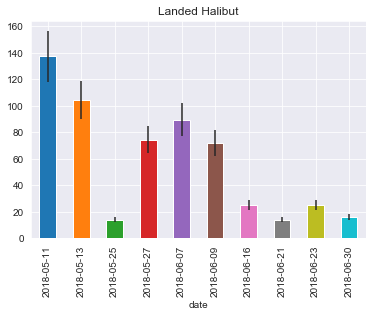

In [29]:
#make a pretty little graphs
halibut_catch = fish[(fish['variable'] == 'Pacific halibut') & (fish['catch_result_type_code']=='K')]
halibut_catch.set_index('date', inplace=True)
halibut_catch['estPrp'].plot(kind='bar', title='Landed Halibut', yerr=np.sqrt(halibut_catch['estPrp.v']))

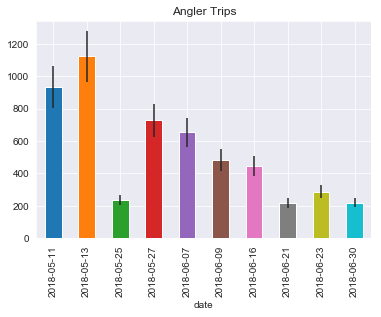

In [31]:
effort = fish[(fish['variable'] == 'anglers')]
effort.set_index('date', inplace=True)
effort['estPrp'].plot(kind='bar', title='Angler Trips', yerr=np.sqrt(effort['estPrp.v']).values)

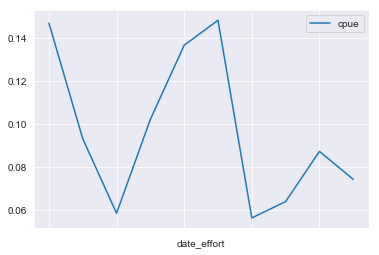

In [46]:
cpue = effort.join(halibut_catch,lsuffix='_effort', rsuffix='_halibut')
cpue['cpue'] = cpue['estPrp_halibut'] / cpue['estPrp_effort']
cpue = cpue[['date_effort', 'cpue']]
cpue.set_index('date_effort', inplace=True)
cpue.plot(kind='line')